In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

Imports Successful


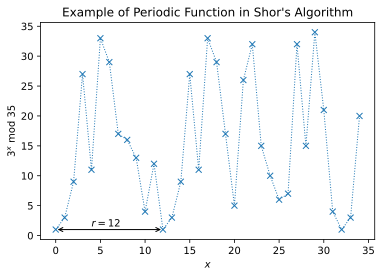

In [2]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

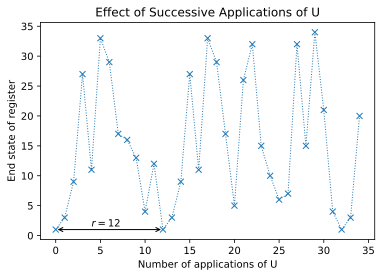

In [3]:
ax.set(xlabel='Number of applications of U', ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

In [4]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [5]:
# Specify variables
n_count = 8 # number of counting qubits
a = 7

In [6]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [7]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And ancilla register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw('text')

┌───┐                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────»
      ├───┤       │                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────»
      ├───┤       │              │                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────»
      ├───┤       │              │              │                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤       │              │              │              │       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      └───┘┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐»
 q_8: ─────┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├»
           │             ││             ││             ││             │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├»
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├»
      ┌───┐│             ││             ││             ││             │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ───────■─────────────────────────────────────────────────────────»
«             │                                                         »
« q_5: ───────┼───────────────■─────────────────────────────────────────»
«             │               │                                         »
« q_6: ───────┼───────────────┼───────────────■─────────────────────────»
«             │               │               │                         »
« q_7: ───────┼───────────────┼───────────────┼────────────────■────────»
«      ┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌──────┴┼───────┐»
« q_8: ┤0             ├┤0             ├┤0             ├┤0      │       ├»
«      │              ││              ││              ││               │»
« q_9: ┤1             ├┤1             ├┤1             ├┤1              ├»
«      │  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │»
«q_10: ┤2             ├┤2             ├┤2             ├┤2              ├»
«      │              ││              ││              ││               │»
«q_11: ┤3             ├┤3             ├┤3             ├┤3              ├»
«      └──────────────┘└──────────────┘└──────────────┘└───────────────┘»
« c: 8/═════════════════════════════════════════════════════════════════»
«                                                                       »
«      ┌───────┐┌─┐                  

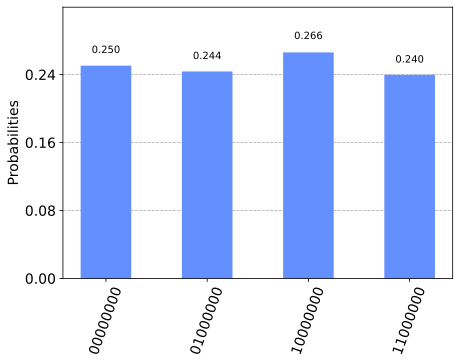

In [8]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0    00000000(bin) = 0(dec)    0/256 = 0.00
1   01000000(bin) = 64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [10]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [11]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


In [12]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [13]:
a2jmodN(7, 2049, 53)

47

In [14]:
N = 15

In [15]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


In [16]:
from math import gcd # greatest common divisor
gcd(a, 15)

1

In [17]:
def qpe_amod15(a):
    n_count = 3
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialise counting qubits in state |+>
    qc.x(3+n_count) # And ancilla register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    backend = Aer.get_backend('qasm_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    result = execute(qc, backend, shots=1, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [18]:
np.random.seed(3) # This is to make sure we get reproduceable results
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

Register Reading: 000
Corresponding Phase: 0.000000


Fraction(0, 1)

In [19]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

1


In [20]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[15, 1]


In [21]:
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, 15), gcd(a**(r//2)+1, 15)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess != 1 and (15 % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 010
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***
